In [1]:
import pandas as pd
from collections import defaultdict

merchant_items = defaultdict(list)

In [2]:
path = 'data/'

In [6]:
df = pd.read_csv(path+'hist_data.csv', nrows=10000)
df.head()

,buyer_id,pav_order_id,created,item_id,count,price_sold,flag_weight_goods,weight
0,95203091,98506637863,2021-07-01 00:03:44,202808329,1.000,79.990,False,11.14
1,95203091,98506637863,2021-07-01 00:03:44,202953905,1.072,44.945,True,11.14
2,95203091,98506637863,2021-07-01 00:03:44,203566452,1.000,69.990,False,11.14
3,95203091,98506637863,2021-07-01 00:03:44,202820143,1.972,41.295,True,11.14
4,95203091,98506637863,2021-07-01 00:03:44,204400422,1.000,269.990,False,11.14


In [7]:
def filter_column(ds, col, min_freq, free_col='rating'):
    
    temp = ds.groupby(col, as_index=False).agg({free_col:'count'})
    filtered = temp.loc[temp[free_col] >= min_freq, col].values
    ds = ds.loc[(ds[col].isin(filtered))].copy()

    return ds

df = filter_column(df, col='pav_order_id', min_freq=5, free_col='price_sold')
df = filter_column(df, col='item_id', min_freq=50,free_col='price_sold')

In [8]:
user2idx = {v: k for k, v in enumerate(df.pav_order_id.unique())}
item2idx = {v: k for k, v in enumerate(df.item_id.unique())}
print(len(item2idx), len(user2idx))
idx2user = {k:v for v, k in user2idx.items()}
idx2item = {k:v for v, k in item2idx.items()}

df['pav_order_id'] = df.pav_order_id.apply(lambda x: user2idx[x])
df['item_id'] = df.item_id.apply(lambda x: item2idx[x])

df.head()

9 363


,buyer_id,pav_order_id,created,item_id,count,price_sold,flag_weight_goods,weight
6,95203091,0,2021-07-01 00:03:44,0,1.002,43.945,True,11.14
7,95203091,0,2021-07-01 00:03:44,1,0.968,52.395,True,11.14
35,95854621,1,2021-07-01 00:16:39,2,3.924,28.145,True,28.23
55,95854621,1,2021-07-01 00:16:39,3,1.044,27.690,True,28.23
70,94767798,2,2021-07-01 00:16:53,4,3.000,49.890,False,69.35


In [9]:
import numpy as np

def get_grouped_data(x):
    
    x = x.sort_values(by=['pav_order_id','created'])
    last_history = set()
    target_basket_x = set()
    target_basket_y = set()
    last_order = x.pav_order_id.values[-1]
    left_of_last_order = len(x.loc[x.pav_order_id==last_order])
    
    for idx, row in x.iterrows():
        if row.pav_order_id != last_order:
            last_history.add(int(row.item_id))
        else:
            if len(target_basket_x) < 0.7 * left_of_last_order:
                target_basket_x.add(int(row.item_id))
            else:
                target_basket_y.add(int(row.item_id))
                
    last_history_vector = np.zeros(len(item2idx))
    tbx_vector = np.zeros(len(item2idx))
    tby_vector = np.zeros(len(item2idx))
    last_history_vector[list(last_history)] = 1
    tbx_vector[list(target_basket_x)] = 1
    tby_vector[list(target_basket_y)] = 1
                
    return last_history_vector, tbx_vector, tby_vector
    
grouped = df.groupby('buyer_id').apply(lambda x: get_grouped_data(x)).reset_index()
print(grouped.shape)
grouped.rename({0:'joined'}, axis=1, inplace=True)
grouped['history_items'] = grouped.joined.apply(lambda x: x[0])
grouped['target_basket_x'] = grouped.joined.apply(lambda x: x[1])
grouped['target_basket_y'] = grouped.joined.apply(lambda x: x[2])
grouped.drop(['joined'], axis=1, inplace=True)
grouped['segment'] = grouped.buyer_id.apply(lambda x: np.random.choice(['train_1','train_2','test_2']))
grouped.head()

(363, 2)


,buyer_id,history_items,target_basket_x,target_basket_y,segment
0,94590204,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",train_1
1,94590324,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",train_1
2,94599587,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",train_1
3,94600013,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0]",train_1
4,94601062,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",train_2


In [10]:
#grouped.to_pickle(path+'grouped.pkl')

In [11]:
import numpy as np
import bottleneck as bn
import torch
from scipy import sparse as sps


def NDCG_binary_at_k_batch(X_pred, heldout_batch, k=20):
    """
    Normalized Discounted Cumulative Gain@k for binary relevance
    ASSUMPTIONS: all the 0's in heldout_data indicate 0 relevance
    """
    batch_users = X_pred.shape[0]
    heldout_batch = sps.csr_matrix(heldout_batch)
    
    idx_topk_part = bn.argpartition(-X_pred, k, axis=1)
    topk_part = X_pred[np.arange(batch_users)[:, np.newaxis], idx_topk_part[:, :k]]
    idx_part = np.argsort(-topk_part, axis=1)

    idx_topk = idx_topk_part[np.arange(batch_users)[:, np.newaxis], idx_part]

    tp = 1.0 / np.log2(np.arange(2, k + 2))
    

    DCG = (heldout_batch[np.arange(batch_users)[:, np.newaxis], idx_topk].toarray() * tp).sum(
        axis=1
    )
    IDCG = np.array([(tp[: min(n, k)]).sum() for n in heldout_batch.getnnz(axis=1)])
    ndcg = DCG / IDCG
    ndcg = ndcg[ndcg > -100]
    return ndcg.mean()


In [12]:
train = grouped.loc[grouped.segment=='train_1']

train_matrix = sps.csr_matrix(np.vstack((train.target_basket_x.values)))
valid_matrix = sps.csr_matrix(np.vstack((train.target_basket_y.values)))

train_2 = grouped.loc[grouped.segment=='train_2'].copy()
test_2 = grouped.loc[grouped.segment=='test_2'].copy()

In [13]:
import yaml
import numpy as np
from pathlib import Path
from scipy import sparse
from src.first_level.fit import fit_first_level

config_file = Path.cwd() / "configs" / "config.yaml"
with config_file.open("r", encoding="utf-8") as file:
    config = yaml.safe_load(file)
    
config['first_level']['models'][0]['model']['encoder']['input_size'] = len(item2idx)
config['first_level']['models'][0]['model']['decoder']['hidden_sizes'][-1] = len(item2idx)

    
train = {
    #"ALS": train_matrix,
    "MultVAE": (
        train_matrix,
        train_matrix,
    ),
    'EASE': train_matrix,
    'SLIM': train_matrix,

}
valid = {
    #"ALS": valid_matrix,
    "MultVAE": (
        train_matrix,
        valid_matrix,
    ),
    'EASE': valid_matrix,
    'SLIM': valid_matrix
}
models = fit_first_level(config["first_level"], train=train, valid=valid)
print(models)

KeyboardInterrupt: 

In [ ]:
from src.fi


model = SAR()
data = sparse.csr_matrix(np.random.randint(low=0, high=2, size=(100, 300)))
metrics = model.fit(train=data, valid=data)

In [19]:
import hnswlib
import numpy as np
import pandas as pd
from tqdm import tqdm

import gzip
from math import asin, cos, sqrt
from multiprocessing import Pool
import os

import dill
import numpy as np
import pandas as pd
import torch
from tqdm import tqdm


def perform_parallel(data, function, n_jobs: int, verbose: bool = True):

    with Pool(n_jobs) as p:
        chunksize = max(1, len(data) // n_jobs)

        result = list(
            tqdm(
                p.imap(function, data, chunksize=chunksize), disable=not verbose, total=len(data),
            )
        )
    return result


class BasePreprocess:
    """
    Class that does processing data from zeppelin notebook to appropriate form for the model
    """

    def __init__(self):
        pass

    def process_df(self, df: pd.DataFrame, case=1) -> pd.DataFrame:

        self.ci = {v: k for k, v in enumerate(df.columns)}
        df = self._preparatory_actions(df)
        data = self._process_rows(df, case=case)
        columns = list(data[0].keys())
        data = pd.DataFrame(data, columns=columns)
        data = self._final_actions(data)
        #data = data.set_index(CUST_ID_COL)
        return data

    def _process_rows(self, dataset: pd.DataFrame, case):
        if case == 1:
            function = self._preprocess_rows1
        return perform_parallel(data=dataset.values, function=function, n_jobs=20)

    def _preprocess_rows(self, val: pd.Series) -> dict:
        raise NotImplementedError

    def _preparatory_actions(self, df: pd.DataFrame) -> pd.DataFrame:
        return df

    def _final_actions(self, df: pd.DataFrame) -> pd.DataFrame:
        return df


class Prep1(BasePreprocess):
    def __init__(self):

        super().__init__()

    def _preprocess_rows1(self, val: pd.Series) -> dict:

        y = val
        row = {}
        for col in self.ci:
            row[col] = val[self.ci[col]]
            
        row['joined_scores'] = row['joined_scores'].split(';')
            
        return row
    
p = Prep1()

In [20]:
models_keys = [x for x in list(models.keys()) if 'ALS' not in x]


def get_score(x, col):
    
    if col != 'target_basket_y':
        col = 'preds_' + col
    
    vector = np.zeros(x['cands'].shape[0])
    
    for idx, cand in enumerate(range(vector.shape[0])):
        vector[idx] = x[col][x['cands'][idx]]
  #  print(vector.mean())
    return vector
    

    
def join_scores(x):
    l = 0
    ans = []
    while l < len(x['scores_MultVAE']):
        
        s = [str(x['cands'][l])]
        if 'label' in x:
            s.append(str(x['label'][l]))
        for key in models_keys:
            s.append(str(round(x[f'scores_{key}'][l], 8)))
        if len(s) > 0:
            ans.append(';'.join(s))
        l += 1
        
    return ans

def join_label(x):
    
    vector = np.zeros(x['cands'].shape[0])
    
    for idx, cand in enumerate(range(vector.shape[0])):
        vector[idx] = x[f'preds_{col}'][x['cands'][idx]]
  #  print(vector.mean())
    return vector

def batched_contstruc_2_lvl(df, models, top_cands=30, num_chunks=10):
    
    res1 = pd.DataFrame()
    res2 = pd.DataFrame()
    
    for chunk in tqdm(np.array_split(df, num_chunks)):
        x, y = construct_2_lvl(chunk, models, top_cands)
        res1 = pd.concat([res1, x])
        res2 = pd.concat([res2, y])
        
    return res1, res2

def construct_2_lvl(df, models, top_cands=30):
    
    matrix = np.vstack((df.target_basket_x.values))

    
    for key in models_keys:

        model = models[key]
        recs = []
        preds = model.predict(matrix)
        for user in range(matrix.shape[0]):
            if key == 'EASE':
                recs.append(preds[user].tolist()[0])
            else:
                recs.append(preds[user].tolist())

        df[f'preds_{key}'] = recs
        if 'target_basket_y' in df.columns:
            metric = NDCG_binary_at_k_batch(preds, np.vstack((df.target_basket_y.values)), 20)
            print(key, metric)
    
    df['cands'] = df.preds_EASE.apply(lambda x: np.argsort(np.array(x))[-top_cands:])
        
    print('all models predicted')
    for key in models_keys:
        print(key)
        df[f'scores_{key}'] = df.apply(lambda x: get_score(x, col=key), axis=1)

    print('we got all scores')

    if 'target_basket_y' in df.columns:
        df['label'] = df.apply(lambda x: get_score(x, col='target_basket_y'), axis=1)

    print('joining scores')
    df['joined_scores'] = df.apply(lambda x: join_scores(x), axis=1)
    print('exploding')
    
    user_col = 'buyer_id' if 'buyer_id' in df.columns else  'pav_order_id'
    parsed = df[[user_col,'joined_scores']].explode('joined_scores')

    #parsed['joined_scores'] = parsed['joined_scores'].apply(lambda x: x.split(";"))
    parsed = p.process_df(parsed, case=1)
    
    
    
    final_cols = ['cands']
    if 'label' in df.columns:
        final_cols.append('label')
    final_cols.extend(models_keys)
    
    for idx, col in enumerate(final_cols):
        parsed[col] = parsed.joined_scores.apply(lambda x: x[idx])
        if col == 'cands':
            parsed[col] = parsed[col].astype(np.int32)
        else:
            parsed[col] = parsed[col].astype(np.float32)

    parsed.drop(['joined_scores'], axis=1, inplace=True)
    return parsed, df



In [21]:
train_boosting, _ = batched_contstruc_2_lvl(train_2, models, num_chunks=1)

  0%|          | 0/1 [00:00<?, ?it/s]
Reading dataset in memory: 0it [00:00, ?it/s]
Reading dataset in memory: 429it [00:00, 4287.48it/s]
Reading dataset in memory: 899it [00:00, 4529.66it/s]
Reading dataset in memory: 1413it [00:00, 4807.73it/s]
Reading dataset in memory: 1894it [00:00, 4680.99it/s]
Reading dataset in memory: 2365it [00:00, 4689.13it/s]
Reading dataset in memory: 2881it [00:00, 4843.73it/s]
Reading dataset in memory: 3406it [00:00, 4975.37it/s]
Reading dataset in memory: 3937it [00:00, 5079.78it/s]
Reading dataset in memory: 4464it [00:00, 5138.66it/s]
Reading dataset in memory: 4979it [00:01, 5083.36it/s]
Reading dataset in memory: 5488it [00:01, 4990.77it/s]
Reading dataset in memory: 5988it [00:01, 4983.17it/s]
Reading dataset in memory: 6487it [00:01, 4976.46it/s]
Reading dataset in memory: 6985it [00:01, 4805.74it/s]
Reading dataset in memory: 7467it [00:01, 4687.16it/s]
Reading dataset in memory: 7937it [00:01, 4595.94it/s]
Reading dataset in memory: 8435it [00:

MultVAE 0.08734730214698307
EASE 0.15325907465829652
SLIM 0.04455862678729088
all models predicted
MultVAE
EASE
SLIM
we got all scores
joining scores
exploding



100%|██████████| 1/1 [01:44<00:00, 104.01s/it]


In [22]:
test_boosting, test2_mod = batched_contstruc_2_lvl(test_2, models, num_chunks=3)

  0%|          | 0/3 [00:00<?, ?it/s]
Reading dataset in memory: 0it [00:00, ?it/s]
Reading dataset in memory: 217it [00:00, 2168.44it/s]
Reading dataset in memory: 551it [00:00, 2854.87it/s]
Reading dataset in memory: 981it [00:00, 3511.30it/s]
Reading dataset in memory: 1388it [00:00, 3729.30it/s]
Reading dataset in memory: 1849it [00:00, 4045.35it/s]
Reading dataset in memory: 2313it [00:00, 4246.98it/s]
Reading dataset in memory: 2770it [00:00, 4351.39it/s]
Reading dataset in memory: 3227it [00:00, 4418.71it/s]
Reading dataset in memory: 3719it [00:00, 4074.23it/s]

Predict with MultVAE: 100%|██████████| 30/30 [00:01<00:00, 29.94it/s]
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide


MultVAE 0.08796852828677772
EASE 0.15155855652276434
SLIM 0.046032334222727046
all models predicted
MultVAE
EASE
SLIM
we got all scores
joining scores
exploding



 33%|███▎      | 1/3 [02:01<04:02, 121.44s/it]
Reading dataset in memory: 0it [00:00, ?it/s]
Reading dataset in memory: 461it [00:00, 4603.28it/s]
Reading dataset in memory: 461it [00:29, 4603.28it/s]
Reading dataset in memory: 697it [00:29, 19.04it/s]  
Reading dataset in memory: 1143it [00:29, 40.56it/s]
Reading dataset in memory: 1595it [00:29, 71.21it/s]
Reading dataset in memory: 2002it [00:29, 109.99it/s]
Reading dataset in memory: 2461it [00:29, 171.23it/s]
Reading dataset in memory: 2922it [00:29, 256.25it/s]
Reading dataset in memory: 3719it [00:30, 123.66it/s]

Predict with MultVAE: 100%|██████████| 30/30 [00:01<00:00, 22.46it/s]


MultVAE 0.08980913768819553
EASE 0.15261857326839218
SLIM 0.04244653822070713
all models predicted
MultVAE
EASE
SLIM
we got all scores
joining scores
exploding



 67%|██████▋   | 2/3 [05:41<02:59, 179.57s/it]
Reading dataset in memory: 0it [00:00, ?it/s]
Reading dataset in memory: 534it [00:00, 5338.12it/s]
Reading dataset in memory: 1068it [00:00, 5167.19it/s]
Reading dataset in memory: 1595it [00:00, 5210.96it/s]
Reading dataset in memory: 2117it [00:00, 5040.67it/s]
Reading dataset in memory: 2746it [00:00, 5478.09it/s]
Reading dataset in memory: 3719it [00:00, 5591.22it/s]

Predict with MultVAE: 100%|██████████| 30/30 [00:00<00:00, 33.45it/s]


MultVAE 0.08558744114761602
EASE 0.14645585147858
SLIM 0.045238885039640256
all models predicted
MultVAE
EASE
SLIM
we got all scores
joining scores
exploding



100%|██████████| 3/3 [09:21<00:00, 187.09s/it]


In [23]:
from  matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline 


def decode_scores(x):
    vector = np.zeros(len(item2idx))-2
    for el in x.joined:
        t1,t2 = el.split('_')
        vector[int(float(t1))] = float(t2)
    return vector
    
    
    
def plotImp(model, X, num=20, fig_size=(40, 20)):
    feature_imp = pd.DataFrame({"Value": model.feature_importances_, "Feature": X})
    feature_imp = feature_imp.sort_values(by="Value", ascending=False)[0:num]

    plt.figure(figsize=fig_size)
    sns.set(font_scale=5)
    sns.barplot(
        x="Value", y="Feature", data=feature_imp,
    )
    plt.title("LightGBM Features (avg over folds)")
    plt.tight_layout()
    plt.savefig(path)
    plt.show()

    feature_imp.set_index("Value", inplace=True)

    
import xgboost
from sklearn.metrics import roc_auc_score as auc


FEATURES = models_keys.copy()

model = xgboost.XGBClassifier()
model.fit(train_boosting[FEATURES], train_boosting['label'])
test_boosting['preds'] = model.predict_proba(test_boosting[FEATURES])[:,1]
test_boosting['joined'] = test_boosting.apply(lambda x: f'{x.cands}_{x.preds}', axis=1)
test_grouped = test_boosting.groupby('buyer_id').agg({'joined':list}).reset_index()
test_grouped['preds_boosting'] = test_grouped.apply(lambda x: decode_scores(x), axis=1)
test_grouped.head()                                   
auc(test_boosting['label'], test_boosting['preds'])

0.7533032212768079

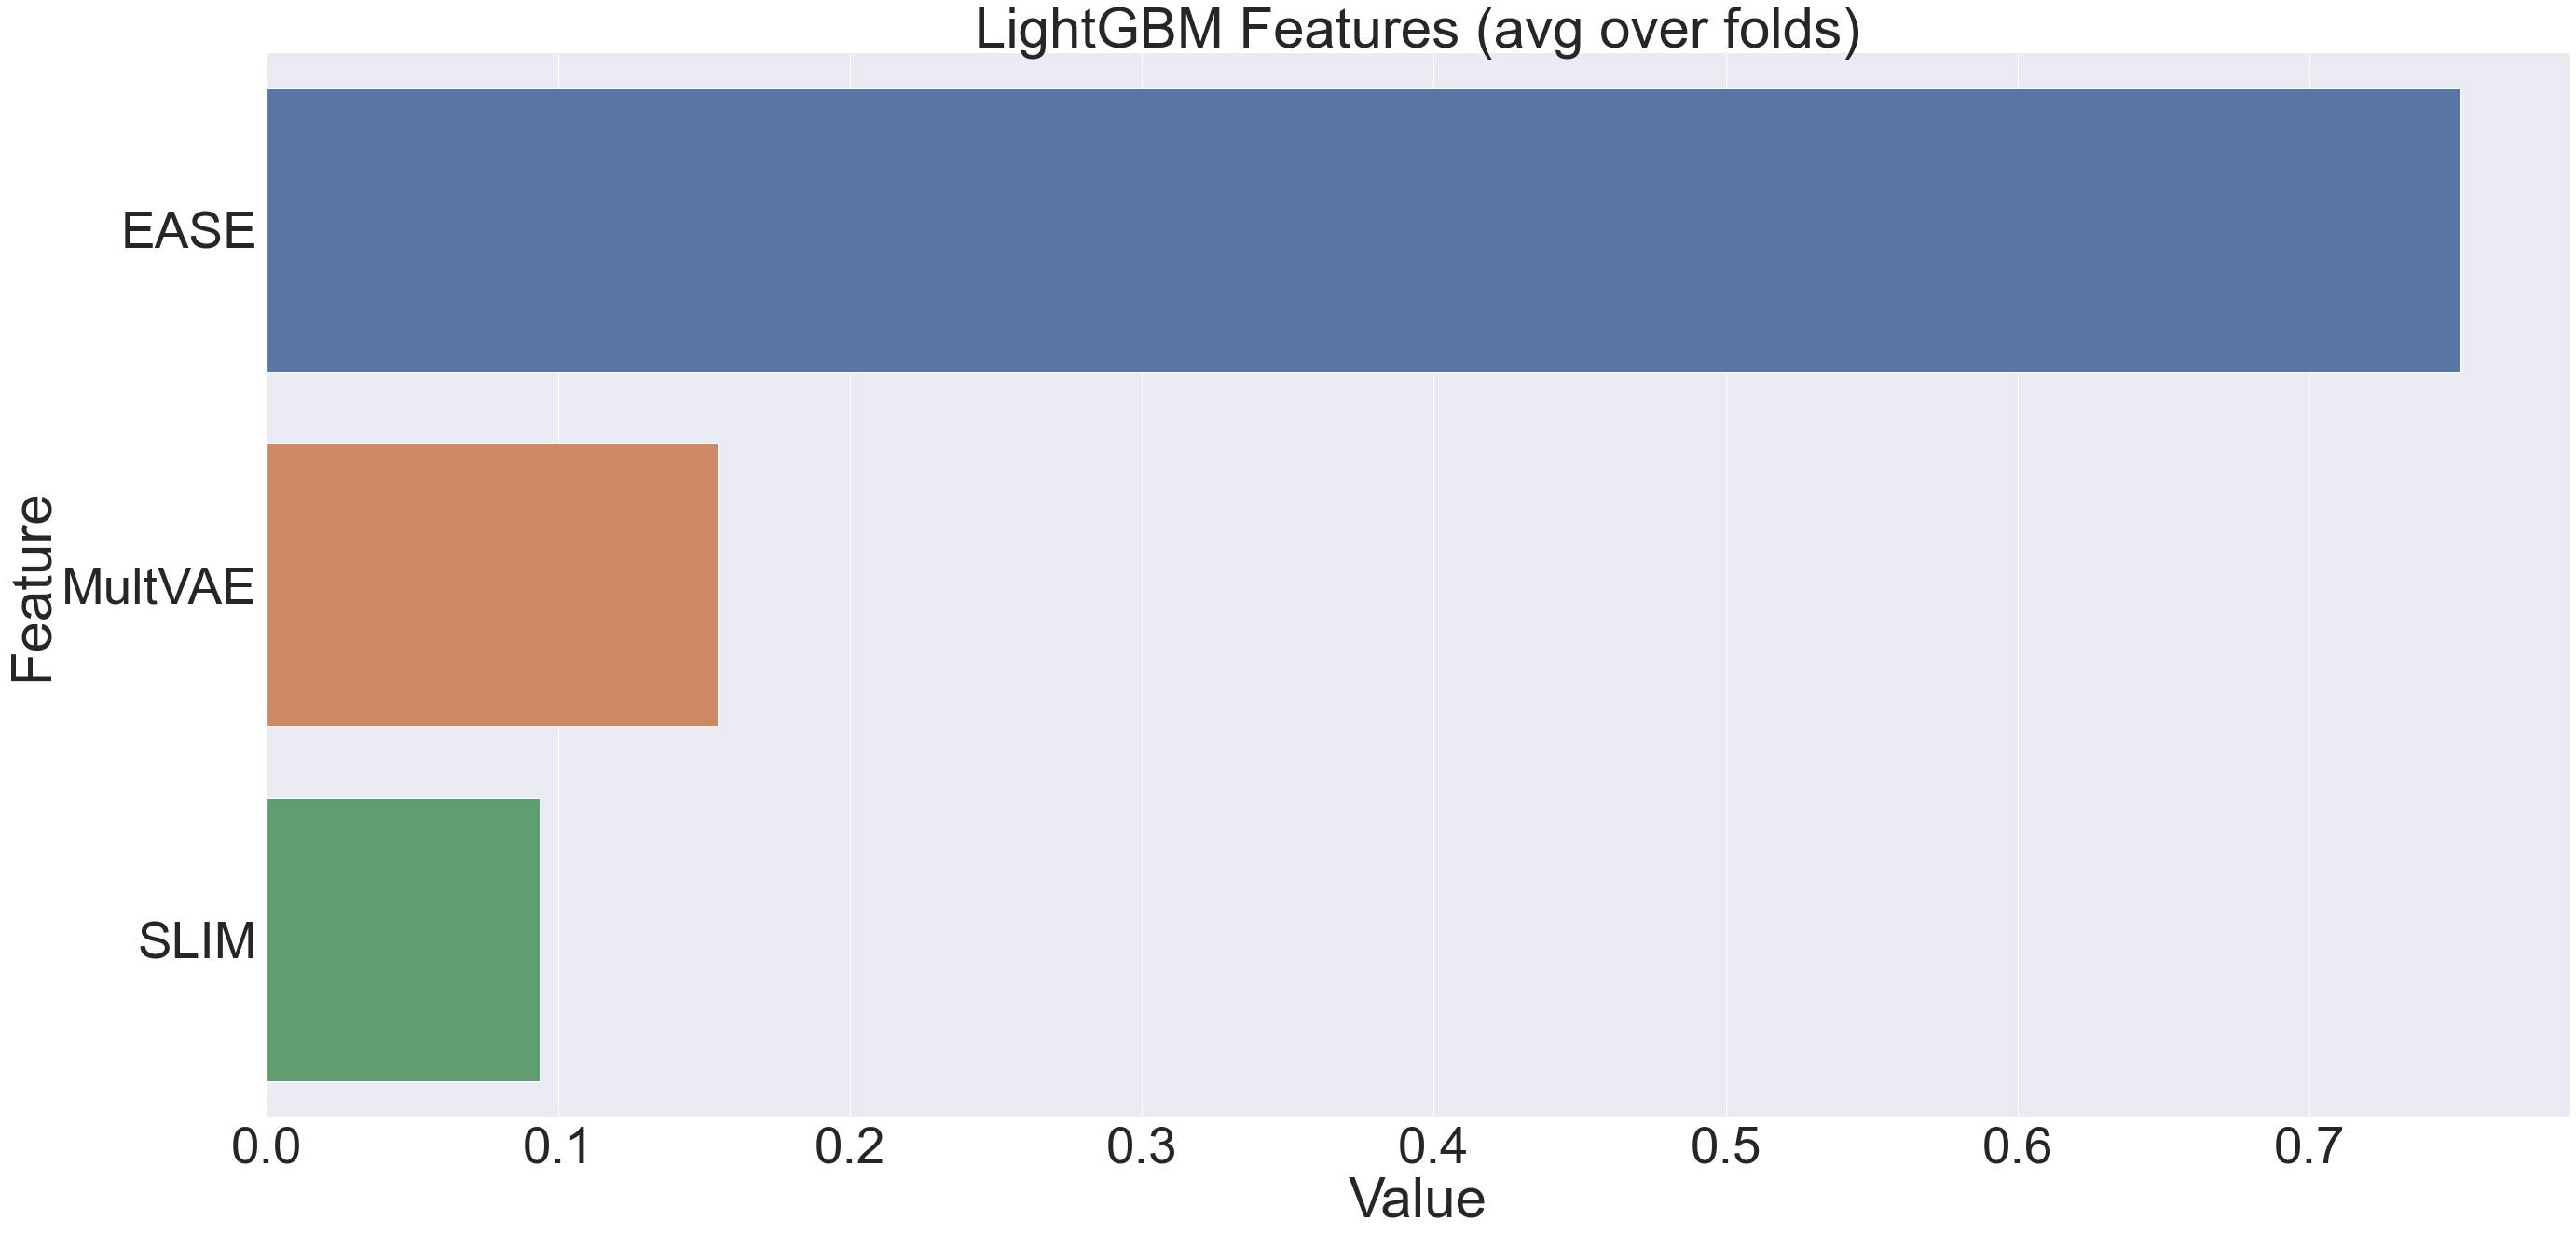

In [24]:
plotImp(model, FEATURES)

In [25]:
final_test = test2_mod.merge(test_grouped)

In [26]:
for el in models_keys + ['boosting']:
    metric = NDCG_binary_at_k_batch(np.vstack((final_test['preds_'+el].values)),
                                    np.vstack((final_test.target_basket_y.values)), 20)
    print(el, metric)
    

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide


MultVAE 0.08779497629282285
EASE 0.15022132572163718
SLIM 0.04456921555200555
boosting 0.15176205847625243


## Testing

In [27]:
test_data = pd.read_csv(path+'test.csv')
print(test_data.shape)
test_data.head()

(1081420, 7)


,buyer_id,pav_order_id,created,item_id,count,price_sold,flag_weight_goods
0,94640077,98519243164,2021-08-30 17:56:31,203053459,1.00,67.62,False
1,95865222,98512083628,2021-07-26 16:17:21,202967705,1.14,406.80,True
2,95147155,98519972197,2021-09-02 21:54:18,203551512,1.00,52.77,False
3,94832207,98518646272,2021-08-28 10:43:23,202801712,1.00,92.89,False
4,95483101,98510857920,2021-07-20 14:27:08,203416702,2.00,238.99,False


In [28]:
def get_preds(x):
    
    basket = [item2idx[t] for t in x if t in item2idx]
    vector = np.zeros(len(item2idx))
    vector[basket] = 1
    
    return vector

def get_final_recs(x):
    vector = np.argsort(-x)[:100]
    vector = [idx2item[t] for t in vector if t in idx2item][:20]
    
    return vector

pred = test_data.groupby(['pav_order_id'])['item_id'].agg([('basket', list)]).reset_index()
pred.rename({'basket':'target_basket_x'}, axis=1, inplace=True)
pred['target_basket_x'] = pred.target_basket_x.apply(lambda x: get_preds(x))
#pred['target_basket_x'] = pred.target_basket_x.apply(lambda x: [0]+[item2idx[t] for t in x if t in item2idx])
pred.head()

,pav_order_id,target_basket_x
0,4620121489,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,4620121505,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ..."
2,4620121594,"[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, ..."
3,4620121684,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,4620121902,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [29]:

num_chunks = 10

joined = pd.DataFrame()

for chunk in tqdm(np.array_split(pred, num_chunks)):
    
    chunk, _ = batched_contstruc_2_lvl(chunk, models, num_chunks=1)

    chunk['preds'] = model.predict_proba(chunk[FEATURES])[:,1]
    chunk['joined'] = chunk.apply(lambda x: f'{x.cands}_{x.preds}', axis=1)
    chunk = chunk.groupby('pav_order_id').agg({'joined':list}).reset_index()
    chunk['preds_boosting'] = chunk.apply(lambda x: decode_scores(x), axis=1)
    chunk['preds'] = chunk.preds_boosting.apply(lambda x: get_final_recs(x))
    chunk = chunk.set_index('pav_order_id')
    chunk = chunk[['preds']].copy()
    joined = pd.concat([joined, chunk])

joined.head()

  0%|          | 0/1 [00:00<?, ?it/s]

Reading dataset in memory: 0it [00:00, ?it/s]

Reading dataset in memory: 472it [00:00, 4692.60it/s]

Reading dataset in memory: 942it [00:00, 4586.25it/s]

Reading dataset in memory: 1401it [00:00, 4556.39it/s]

Reading dataset in memory: 1885it [00:00, 4663.98it/s]

Reading dataset in memory: 2362it [00:00, 4701.00it/s]

Reading dataset in memory: 2840it [00:00, 4725.05it/s]

Reading dataset in memory: 3332it [00:00, 4786.59it/s]

Reading dataset in memory: 3868it [00:00, 4967.78it/s]

Reading dataset in memory: 4399it [00:00, 5073.75it/s]

Reading dataset in memory: 4907it [00:01, 5055.58it/s]

Reading dataset in memory: 5413it [00:01, 5005.91it/s]

Reading dataset in memory: 5980it [00:01, 5204.38it/s]

Reading dataset in memory: 6637it [00:01, 5613.12it/s]

Reading dataset in memory: 7199it [00:01, 5607.15it/s]

Reading dataset in memory: 7896it [00:01, 5179.22it/s]


Predict with MultVAE:   0%|          | 0/62 [00:00<?, ?it/s]

Predict with 

all models predicted
MultVAE
EASE
SLIM
we got all scores
joining scores
exploding




  0%|          | 0/240750 [00:00<?, ?it/s]

  0%|          | 1/240750 [01:05<4381:31:29, 65.52s/it]

  5%|▌         | 12038/240750 [01:05<14:34, 261.55it/s]

 10%|█         | 24075/240750 [02:12<17:30, 206.34it/s]

 10%|█         | 24075/240750 [02:13<17:30, 206.34it/s]

 10%|█         | 24093/240750 [03:21<34:49, 103.68it/s]

 10%|█         | 24093/240750 [03:21<34:49, 103.68it/s]

 10%|█         | 24094/240750 [03:21<34:56, 103.35it/s]

 11%|█▏        | 27165/240750 [04:21<44:54, 79.28it/s] 

 11%|█▏        | 27165/240750 [04:21<44:54, 79.28it/s]

 14%|█▎        | 33075/240750 [04:21<23:48, 145.39it/s]

 16%|█▌        | 37442/240750 [05:17<15:46, 214.88it/s]

 17%|█▋        | 41610/240750 [05:17<24:20, 136.31it/s]

 17%|█▋        | 41610/240750 [05:17<24:20, 136.31it/s]

 24%|██▍       | 57499/240750 [05:17<08:24, 363.54it/s]

 55%|█████▍    | 132408/240750 [05:17<00:57, 1890.36it/s]

 60%|█████▉    | 144445/240750 [06:20<02:01, 791.67it/s] 

 60%|█████▉    | 144445/240750 [06:20<0

all models predicted
MultVAE
EASE
SLIM
we got all scores
joining scores
exploding




  0%|          | 0/240750 [00:00<?, ?it/s]

  0%|          | 1/240750 [00:53<3577:59:13, 53.50s/it]

  0%|          | 2/240750 [01:45<3507:23:47, 52.45s/it]

  0%|          | 3/240750 [02:52<3968:31:33, 59.34s/it]

 10%|█         | 25089/240750 [02:52<13:03, 275.38it/s]

 18%|█▊        | 44420/240750 [02:53<05:40, 577.13it/s]

 23%|██▎       | 55703/240750 [03:52<08:40, 355.43it/s]

 23%|██▎       | 55703/240750 [04:55<16:21, 188.56it/s]Process ForkPoolWorker-114:
Process ForkPoolWorker-115:
Process ForkPoolWorker-106:

Process ForkPoolWorker-116:
Process ForkPoolWorker-119:
Process ForkPoolWorker-117:
Process ForkPoolWorker-118:
Process ForkPoolWorker-105:
Process ForkPoolWorker-112:
Process ForkPoolWorker-120:
Process ForkPoolWorker-104:
Process ForkPoolWorker-113:
Process ForkPoolWorker-107:
Process ForkPoolWorker-111:
Process ForkPoolWorker-109:
Process ForkPoolWorker-108:
Process ForkPoolWorker-102:
Process ForkPoolWorker-103:
Process ForkPoolWorker-110:
Process ForkPoolWorker-1

In [64]:
joined.to_csv(path+'boosting.csv')

In [66]:
joined.shape, pred.shape

((80244, 1), (80244, 2))